#AI VIET NAM
#Naive Object Detection

**Import Libs**

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
import matplotlib.patches as patches

**Download Sample**

##**Single Object**

###**Basic Classification**

In [2]:
dog_image = Image.open("./sample/dog.jpeg")

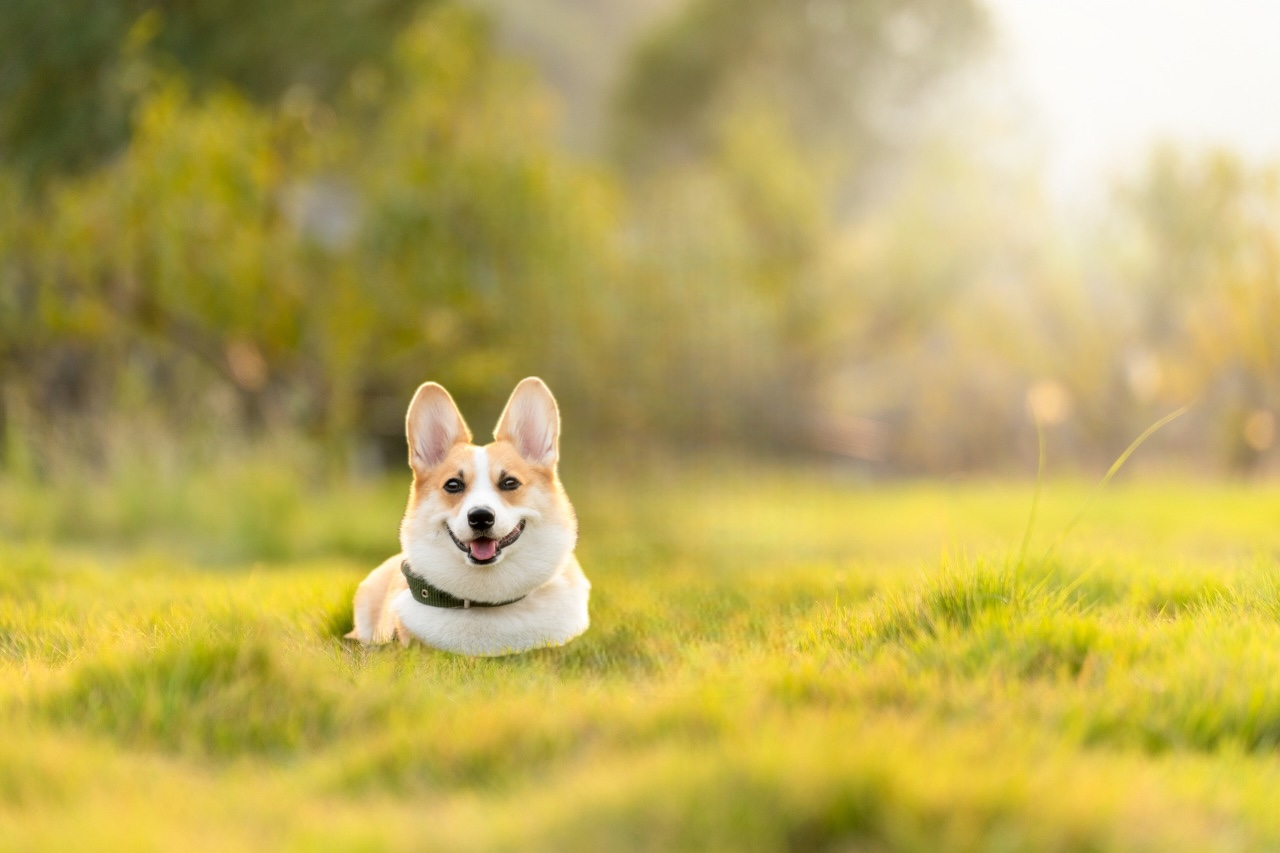

In [3]:
dog_image

In [4]:
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2471, 0.2435, 0.2616]
    ),
])

In [5]:
model = models.resnet18(
    weights=models.ResNet18_Weights.IMAGENET1K_V1
)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:20<00:00, 2.34MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
labels = np.load('./sample/imagenet1000_clsid_to_human.pkl', allow_pickle=True)
labels[1]

'goldfish, Carassius auratus'

In [19]:
def predict(img):
    # Preprocess image
    preprocess_img = transform(img)
    preprocess_img = preprocess_img.unsqueeze(0)
    preprocess_img = preprocess_img.to(device)

    # Predict
    with torch.no_grad():
        output = model(preprocess_img)

    # mặc định output resnet là out_features=1000 
    output = torch.nn.functional.softmax(output, dim=-1)
    print(output.shape)
    prediction = output.argmax()
    print(prediction)
    prob = output[0][prediction].item()

    # Convert idx to label
    label = labels[prediction.item()]
    return prob, label

In [20]:
prob, label = predict(dog_image)
prob, label

torch.Size([1, 1000])
tensor(263)


(0.4503105878829956, 'Pembroke, Pembroke Welsh corgi')

In [28]:
def predict(img):
    # Preprocess image
    preprocess_img = transform(img)
    preprocess_img = preprocess_img.unsqueeze(0)
    preprocess_img = preprocess_img.to(device)

    # Predict
    with torch.no_grad():
        output = model(preprocess_img)

    # mặc định output resnet là out_features=1000
    output = torch.nn.functional.softmax(output, dim=-1)
    prediction = output.argmax()
    prob = output[0][prediction].item()

    # Convert idx to label
    label = labels[prediction.item()]
    return prob, label

###**Naive Object Detection using Sliding Window**

In [15]:
np.array(dog_image).shape

(853, 1280, 3)

In [21]:
def slide_image(img, patch_size=224, step=50):
    # Convert PIL image to numpy array
    np_image = np.array(img)
    h, w, _ = np_image.shape
    patches = []

    # Iterate over the large image
    for y in range(0, h-patch_size+1, step):
        for x in range(0, w-patch_size+1, step):
            # Extract patch (get patch)
            patch = np_image[y:y+patch_size, x:x+patch_size, :]
            patch = Image.fromarray(patch)
            patches.append({
                'x': x,
                'y': y,
                'image': patch
            })

    return patches

In [22]:
image_patches = slide_image(dog_image)

In [23]:
len(image_patches)

286

In [24]:
image_patches[0]

{'x': 0, 'y': 0, 'image': <PIL.Image.Image image mode=RGB size=224x224>}

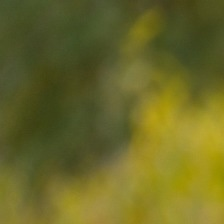

In [25]:
image_patches[0]['image']

In [26]:
prob, label = predict(image_patches[0]['image'])
prob, label

torch.Size([1, 1000])
tensor(92)


(0.04727793484926224, 'bee eater')

In [29]:
for idx in tqdm(range(len(image_patches))):
    prob, label = predict(image_patches[idx]['image'])
    image_patches[idx].update({
        'prob': prob,
        'label': label
    })

100%|██████████| 286/286 [00:09<00:00, 30.19it/s]


In [31]:
image_patches[0]

{'x': 0,
 'y': 0,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.04727793484926224,
 'label': 'bee eater'}

In [32]:
sorted_image_patches = sorted(image_patches, key=lambda x: x['prob'] , reverse=True)

In [33]:
sorted_image_patches[0]

{'x': 350,
 'y': 300,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.9514151215553284,
 'label': 'Pembroke, Pembroke Welsh corgi'}

In [22]:
sorted_image_patches[1]

{'x': 400,
 'y': 300,
 'image': <PIL.Image.Image image mode=RGB size=224x224>,
 'prob': 0.9490092396736145,
 'label': 'Pembroke, Pembroke Welsh corgi'}

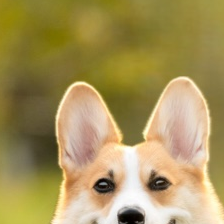

In [23]:
sorted_image_patches[0]['image']

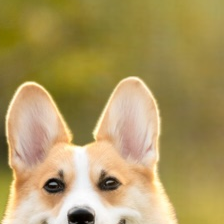

In [24]:
sorted_image_patches[1]['image']

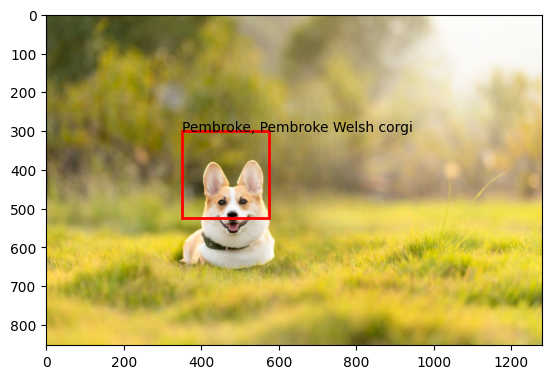

In [26]:
idx = 0

fig, ax = plt.subplots()
ax.imshow(dog_image)

# Create a Rectangle patch
rect = patches.Rectangle(
    (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
    224, 224, linewidth=2, edgecolor='r', facecolor='none'
)
ax.add_patch(rect)
plt.text(
    sorted_image_patches[idx]['x'],
    sorted_image_patches[idx]['y'],
    sorted_image_patches[idx]['label']
)

plt.show()

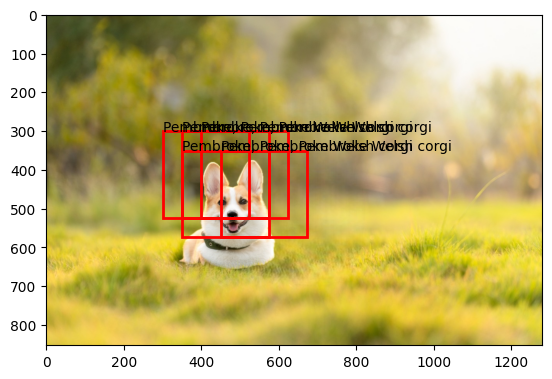

In [27]:
fig, ax = plt.subplots()
ax.imshow(dog_image)
for idx in range(5):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    plt.text(
        sorted_image_patches[idx]['x'],
        sorted_image_patches[idx]['y'],
        sorted_image_patches[idx]['label']
    )
plt.show()

##**Multi Objects**

In [28]:
pets_image = Image.open("./sample/pets.jpeg")

In [29]:
pets_image

Output hidden; open in https://colab.research.google.com to view.

In [30]:
image_patches = slide_image(pets_image)

In [31]:
for idx in tqdm(range(len(image_patches))):
    prob, label = predict(image_patches[idx]['image'])
    image_patches[idx].update({
        'prob': prob,
        'label': label
    })

100%|██████████| 748/748 [00:03<00:00, 209.48it/s]


In [32]:
len(image_patches)

748

In [33]:
sorted_image_patches = sorted(image_patches, key=lambda x: x['prob'] , reverse=True)

In [34]:
sorted_image_patches[:5]

[{'x': 850,
  'y': 500,
  'image': <PIL.Image.Image image mode=RGB size=224x224>,
  'prob': 0.993057370185852,
  'label': 'Pembroke, Pembroke Welsh corgi'},
 {'x': 850,
  'y': 400,
  'image': <PIL.Image.Image image mode=RGB size=224x224>,
  'prob': 0.9878616333007812,
  'label': 'Pembroke, Pembroke Welsh corgi'},
 {'x': 850,
  'y': 450,
  'image': <PIL.Image.Image image mode=RGB size=224x224>,
  'prob': 0.9826048016548157,
  'label': 'Pembroke, Pembroke Welsh corgi'},
 {'x': 900,
  'y': 500,
  'image': <PIL.Image.Image image mode=RGB size=224x224>,
  'prob': 0.9808090925216675,
  'label': 'Pembroke, Pembroke Welsh corgi'},
 {'x': 1100,
  'y': 450,
  'image': <PIL.Image.Image image mode=RGB size=224x224>,
  'prob': 0.9717435240745544,
  'label': 'Pembroke, Pembroke Welsh corgi'}]

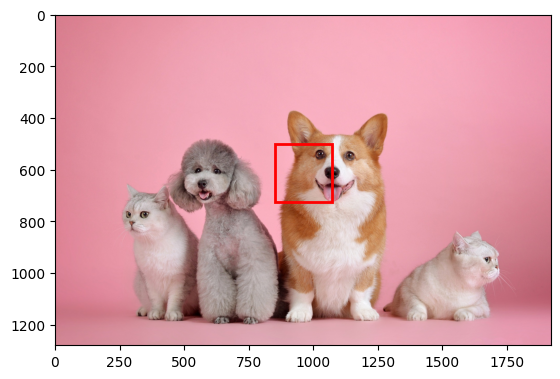

In [35]:
fig, ax = plt.subplots()
ax.imshow(pets_image)
for idx in range(1):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (sorted_image_patches[idx]['x'], sorted_image_patches[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    # plt.text(
    #     sorted_image_patches[idx]['x'],
    #     sorted_image_patches[idx]['y'],
    #     sorted_image_patches[idx]['label']
    # )

plt.show()

### **Is there any way to calculate the intersection between boxes?**

In [36]:
def distance(x1, y1, x2, y2):
    return np.sqrt((y1 - y2) ** 2 + (x2 - y2) ** 2)

Pros:
- Simple
- Easy to implement

Cons:
- Don't know what is close enough
- Does not work well when the bounding box shape vary

In [3]:
def iou(x1, y1, x2, y2, box_shape=224):
    # Extract the coordinates of the two boxes
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + box_shape, y1 + box_shape
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + box_shape, y2 + box_shape

    # Calculate the coordinates of the intersection rectangle
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Calculate the area of the intersection rectangle
    inter_area = max(
        0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)

    # Calculate the area of both rectangles
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area


    # Calculate the IoU
    iou = inter_area / union_area
    print(inter_area, union_area)

    return iou

In [38]:
iou(600, 400, 540, 380, box_shape=200)

0.45985401459854014

In [4]:
iou(20, 20, 40, 40, box_shape=50)

900 4100


0.21951219512195122

### **Filter algorithm**

In [39]:
def filter_function(sorted_image_patches, iou_threshold=0.4, distance_func=iou):
    keep = []
    order = sorted_image_patches.copy()
    order = [item for item in order if item['prob'] > 0.8]
    while len(order) > 0:
        patch = order[0]
        keep.append(patch)

        order = order[1:]

        if len(order) == 0:
            break

        for idx, other_patch in enumerate(order):
            iou_score = distance_func(
                patch['x'], patch['y'], other_patch['x'], other_patch['y']
            )
            if iou_score > iou_threshold:
                order[idx] = None
        order = [item for item in order if item is not None]
    return keep

In [40]:
keep = filter_function(sorted_image_patches, iou_threshold=0.1, distance_func=iou)

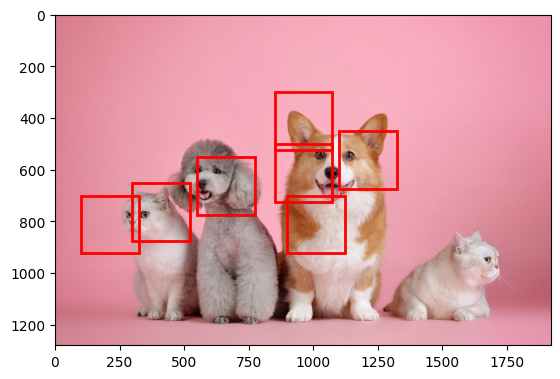

In [41]:
fig, ax = plt.subplots()
ax.imshow(pets_image)
for idx in range(len(keep)):
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (keep[idx]['x'], keep[idx]['y']),
        224, 224, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    # plt.text(
    #     sorted_image_patches[idx]['x'],
    #     sorted_image_patches[idx]['y'],
    #     sorted_image_patches[idx]['label']
    # )

plt.show()